In [12]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter
import cPickle as pickle

In [23]:
# Read the cleaned csv files
# order of the columns: Record ID, Patient ID, Time, Blood Glucose Measurement (calibration), Glucose Measurement
cgm_data = np.array(pd.read_csv('./Relative Time Data/CGMS_Cleaned.csv').as_matrix())
cgm_data = cgm_data[~np.isnan(cgm_data[:,4])]

# order of the columns: Patient ID, Time, Glucose Measurement, Watch # (there are 2)
gwb_data = np.array(pd.read_csv('./Relative Time Data/GWB_Cleaned.csv').as_matrix())
gwb_data = gwb_data[~np.isnan(gwb_data[:,2])]

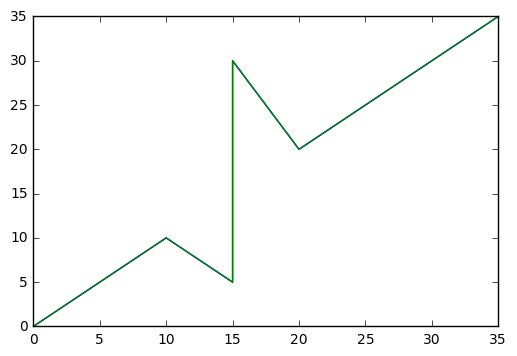

In [101]:
x = [0, 5, 10, 15, 15, 15, 15, 20, 25, 30, 35]
y = [0, 5, 10, 5, 10, 15, 30, 20, 25, 30, 35]
plt.plot(x,y)
plt.show()

In [24]:
# Break up data based on patient

pt_cgm_data = {}
pt_gwb_data = {}
        
for patient_id in np.unique(cgm_data[:,1]).astype(int):
    patient_indices = (cgm_data[:,1]==patient_id)
    value = cgm_data[patient_indices, 0:]
    pt_cgm_data[patient_id] = value[:,0:]

for patient_id in np.unique(gwb_data[:,1]).astype(int):
    patient_indices = (gwb_data[:,0]==patient_id)
    value = gwb_data[patient_indices, 1:]
    pt_gwb_data[patient_id] = value[:,1:]

In [102]:
# For each patient break up the cgm data based on neegative time jumps
# Take the longest block of data for each patient

pt_cgm_longest = {}
for key, value in pt_cgm_data.iteritems():
    dif = np.diff(value[:,2]) #difference in time
    break_point = np.where(dif<0)[0]
    split_data = []
    cur_idx = 0
    a = 0
    for idx in break_point:
        block = value[cur_idx:idx+1,2:] #c olumns: Time, Blood Glucose Measurement (calibration), Glucose Measurement
        block = np.delete(block, 1, axis=1) # delete column BGM (calibration)
        split_data.append(block)
        cur_idx = idx+1
    block = value[cur_idx:,2:] #c olumns: Time, Blood Glucose Measurement (calibration), Glucose Measurement
    block = np.delete(block, 1, axis=1) # delete column BGM (calibration)
    split_data.append(block)
    
    if len(split_data) > 2: # combine fragmented data
        length = [len(block) for block in split_data]
        idx = np.argmin(length)
        combine = np.vstack([split_data[idx-1], split_data[idx]])
        combine = combine[combine[:,0].argsort()]
        split_data = [combine, split_data[(idx+1)%3]]
    
    # find the longest block
    # maybe switch to the one with the smallest MSE wit the interpolated BGM data
    length = [len(block) for block in split_data]
    pt_cgm_longest[key] = split_data[np.argmax(length)]


In [103]:
# Save cgm patient data as pickle
with open('pt_cgm_longest.p', 'wb') as fp:
    pickle.dump(pt_cgm_longest, fp)

In [104]:
# Save all the blocks of data for visualization

pt_cgm = {}
for key, value in pt_cgm_data.iteritems():
    dif = np.diff(value[:,2]) #difference in time
    break_point = np.where(dif<0)[0]
    split_data = []
    cur_idx = 0
    a = 0
    for idx in break_point:
        block = value[cur_idx:idx+1,2:] #c olumns: Time, Blood Glucose Measurement (calibration), Glucose Measurement
        block = np.delete(block, 1, axis=1) # delete column BGM (calibration)
        split_data.append(block)
        cur_idx = idx+1
    block = value[cur_idx:,2:] #c olumns: Time, Blood Glucose Measurement (calibration), Glucose Measurement
    block = np.delete(block, 1, axis=1) # delete column BGM (calibration)
    split_data.append(block)
    
    if len(split_data) > 2: # combine fragmented data
        length = [len(block) for block in split_data]
        idx = np.argmin(length)
        combine = np.vstack([split_data[idx-1], split_data[idx]])
        combine = combine[combine[:,0].argsort()]
        split_data = [combine, split_data[(idx+1)%3]]
        
    # find the longest block
    pt_cgm[key] = split_data


287
766


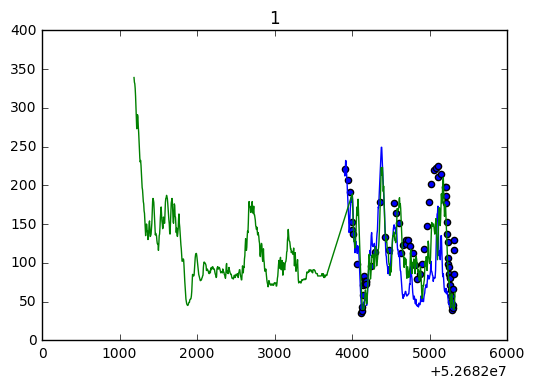

296
278


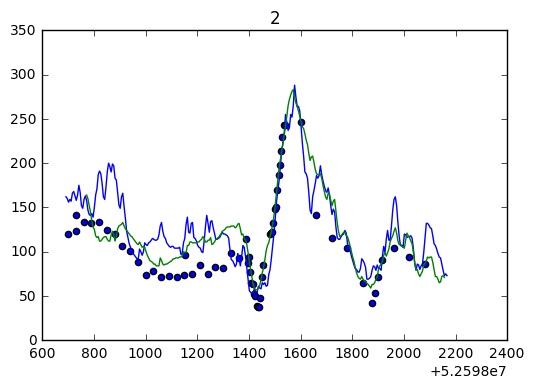

858
923


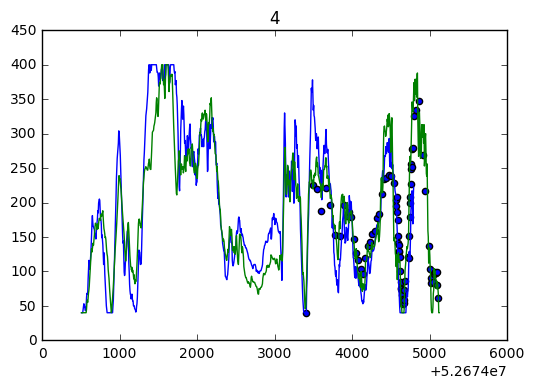

563
576


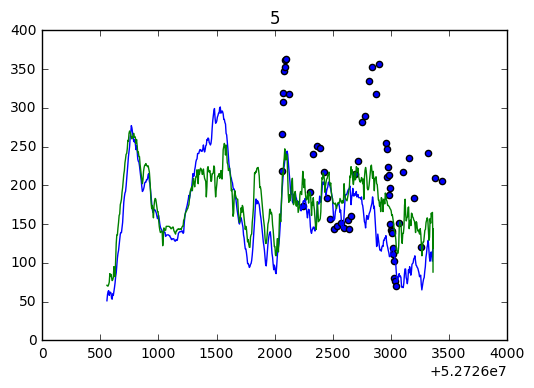

789
660


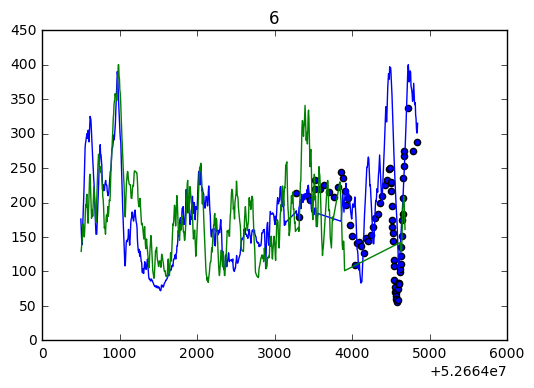

540
546


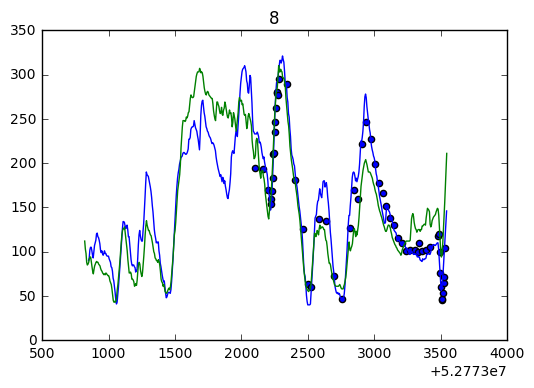

278
861


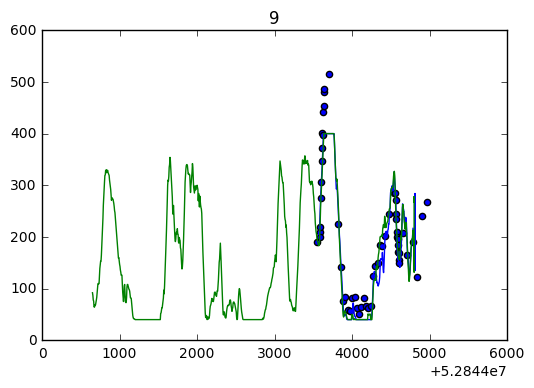

268
282


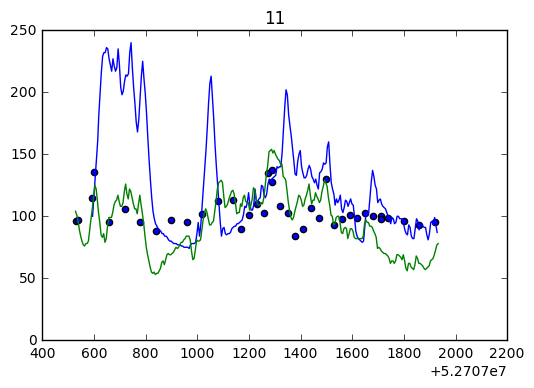

551
551


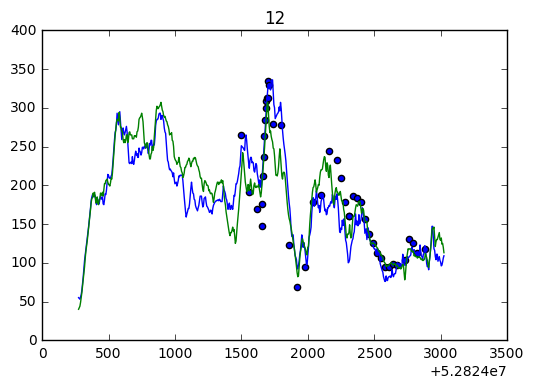

273
822


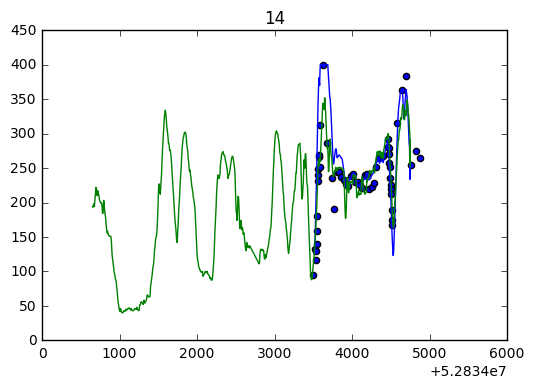

489
489


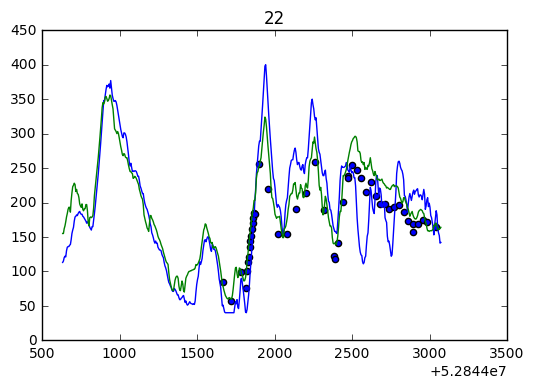

268
262


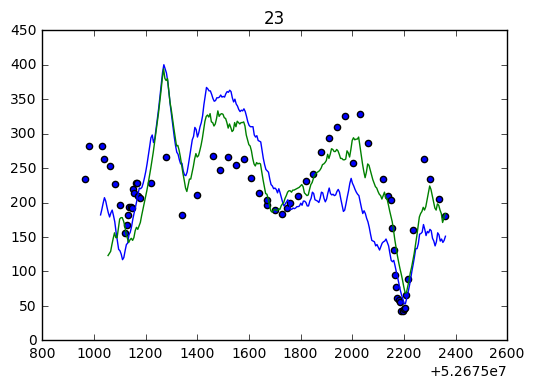

795
794


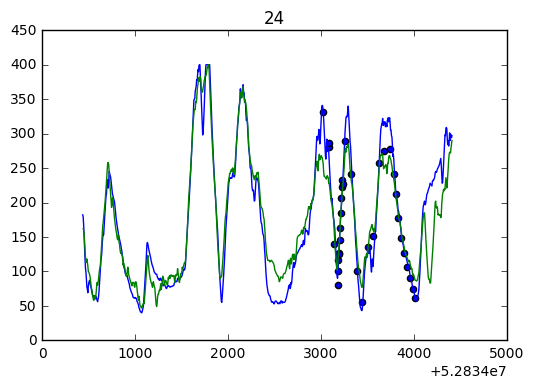

493
267


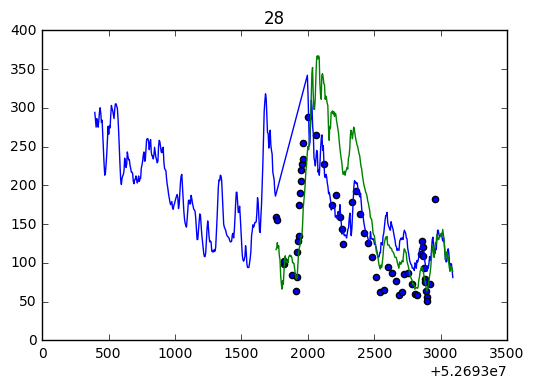

437
553


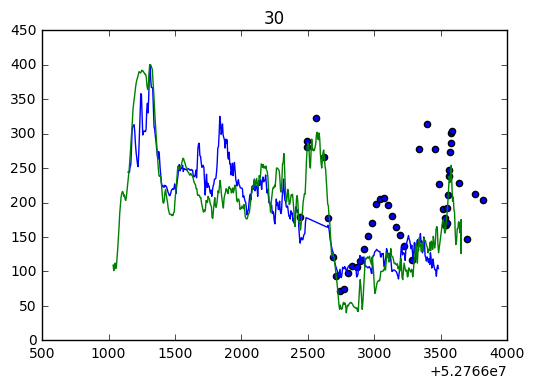

531
240


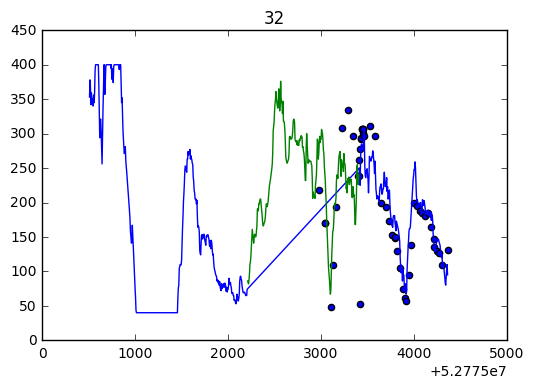

516
537


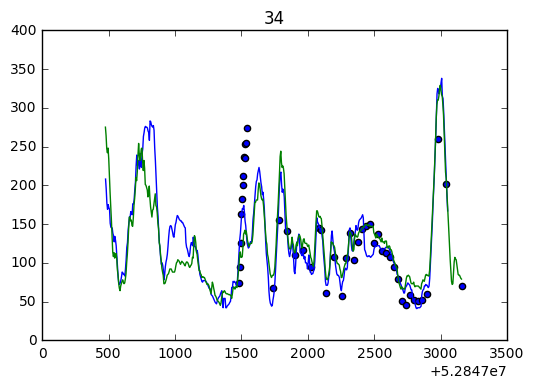

281
282


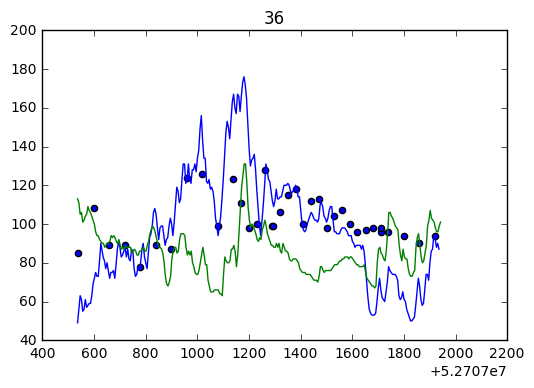

259
277


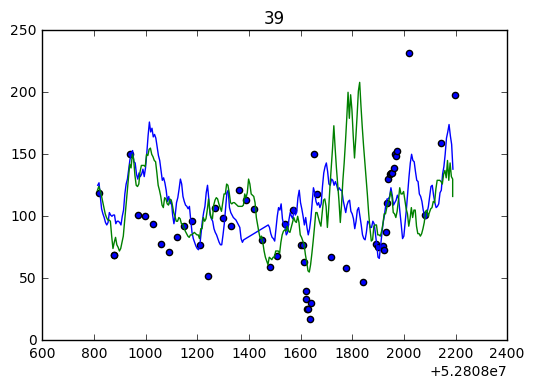

168
168


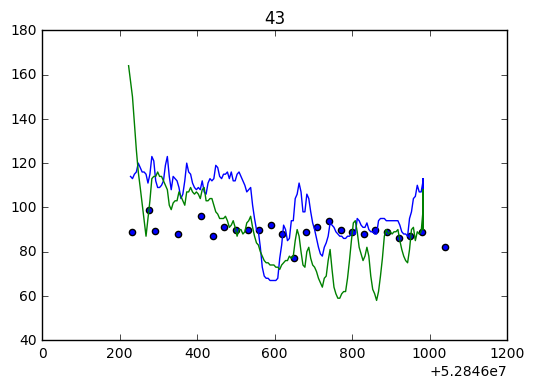

603
822


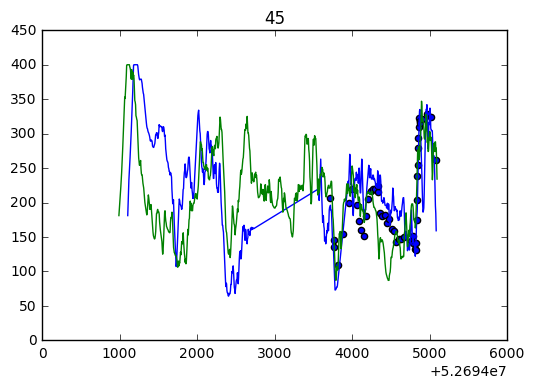

286
450


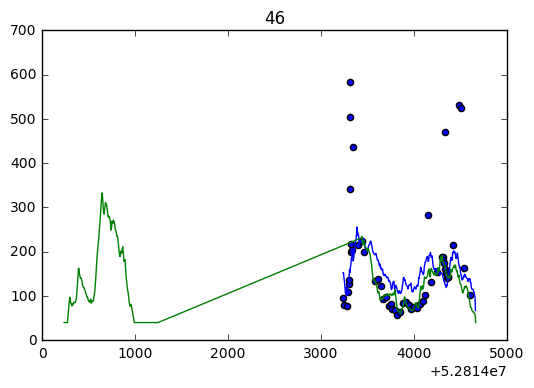

558
557


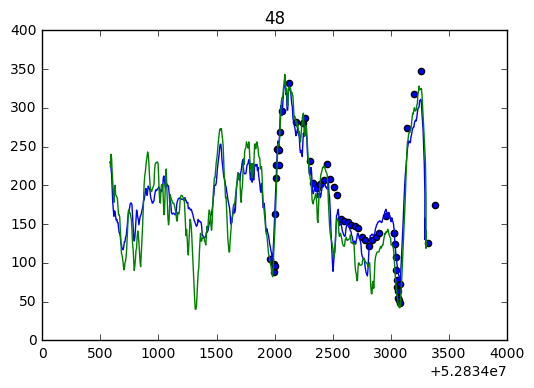

271
551


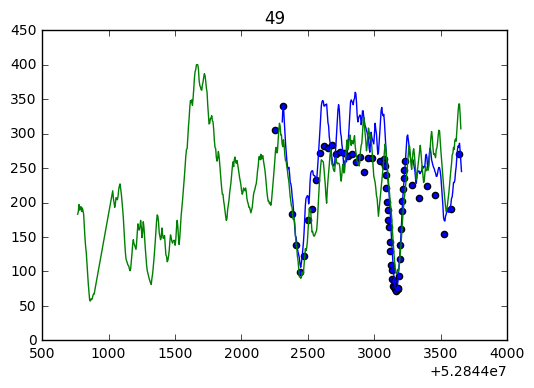

486
485


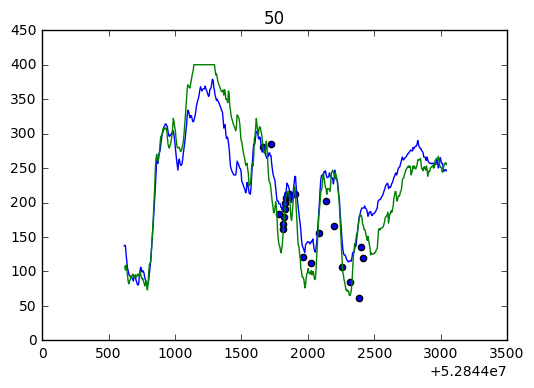

165
131


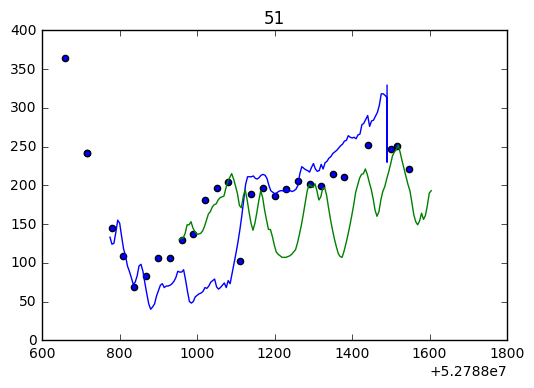

252
264


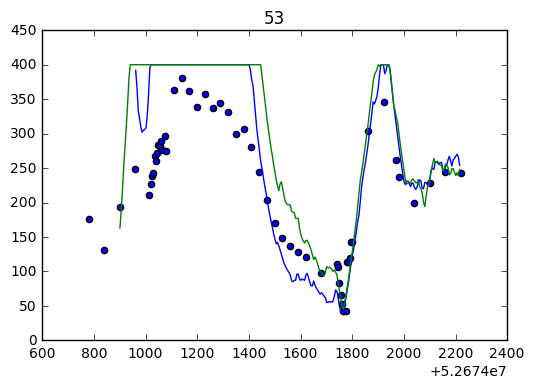

556
302


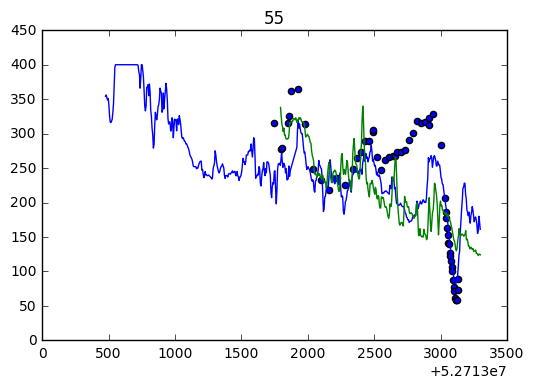

812
662


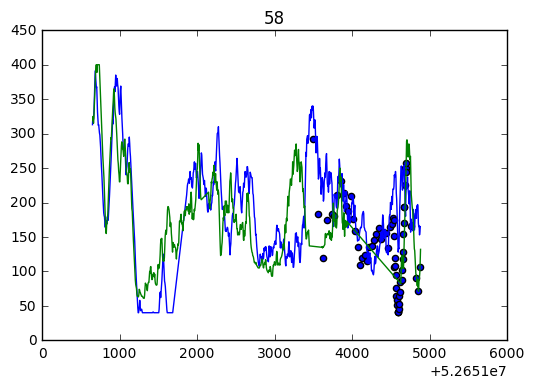

582
583


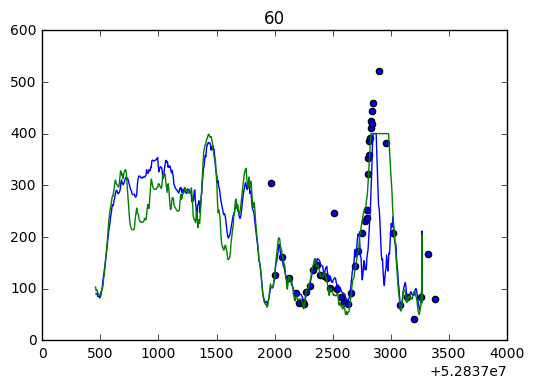

8
298


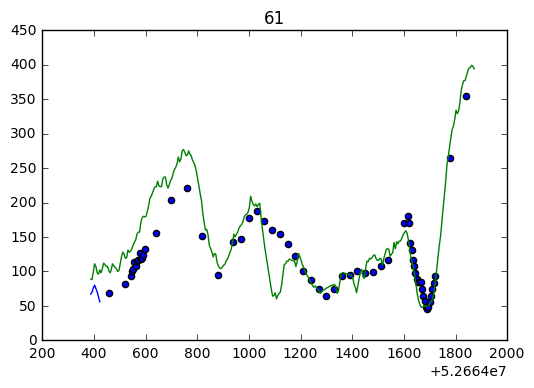

285
284


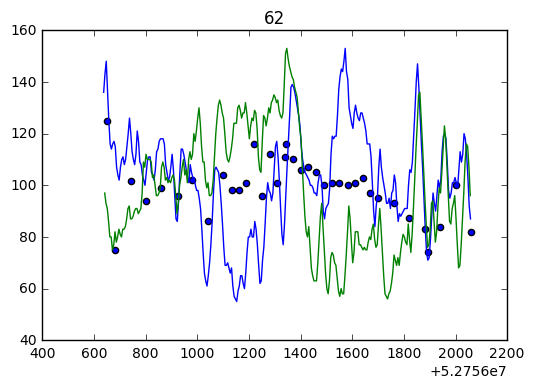

268
237


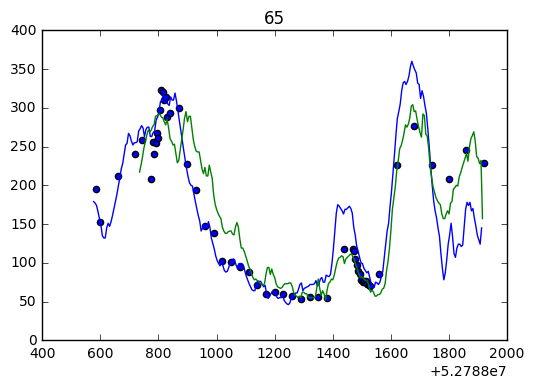

539
551


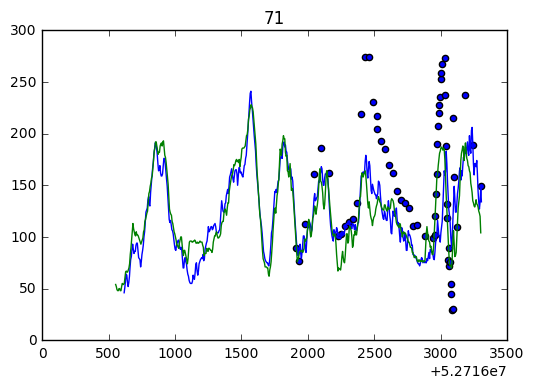

233
269


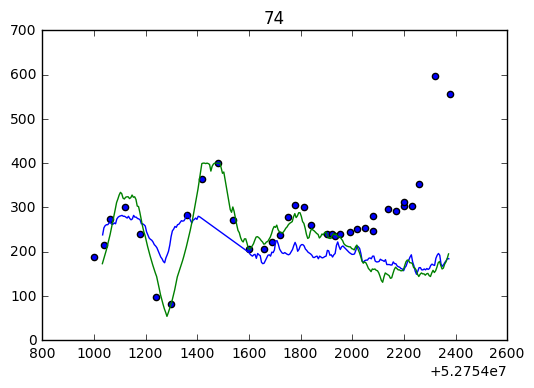

492
563


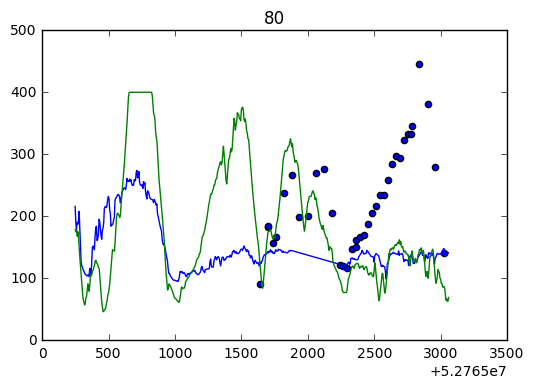

237
225


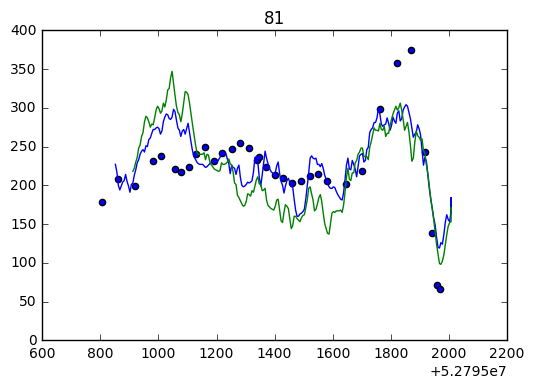

278
264


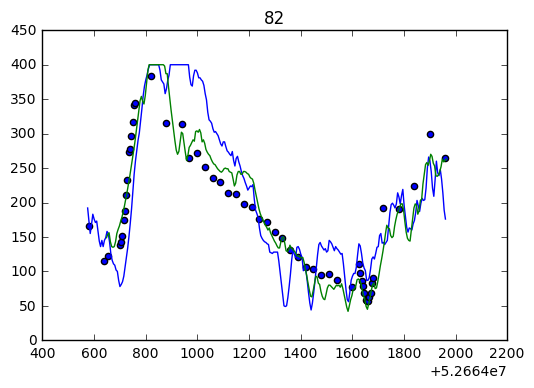

278
279


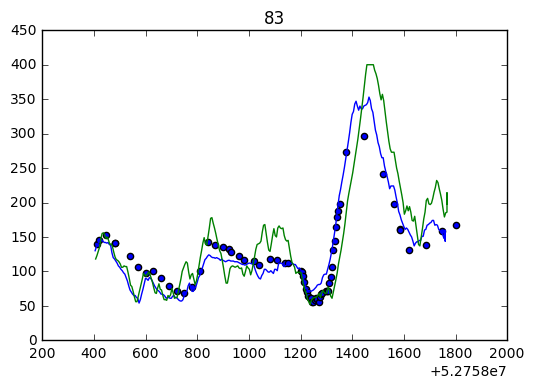

549
550


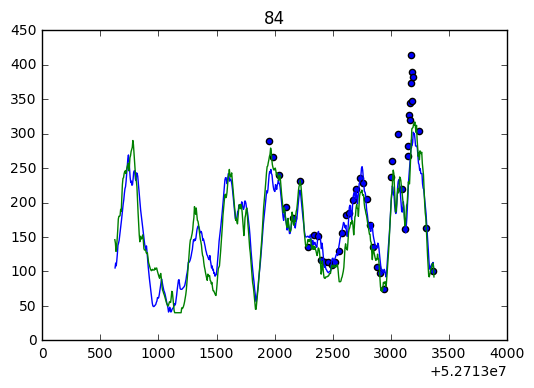

835
836


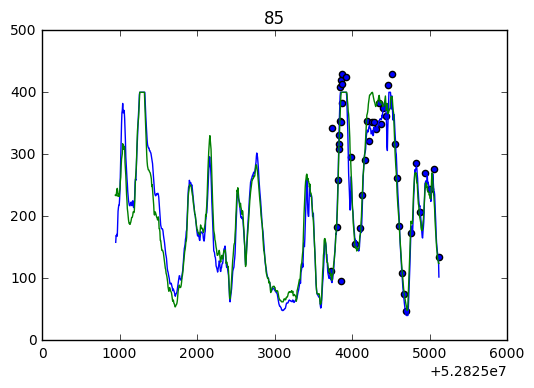

263
14


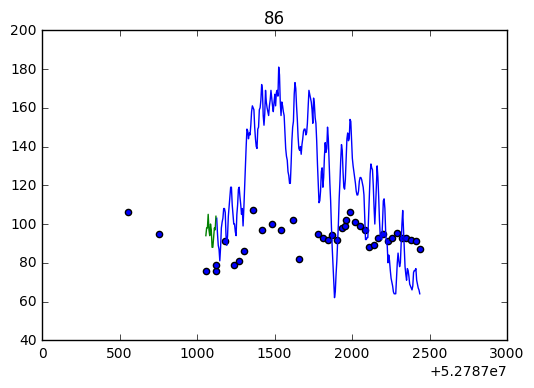

801
279


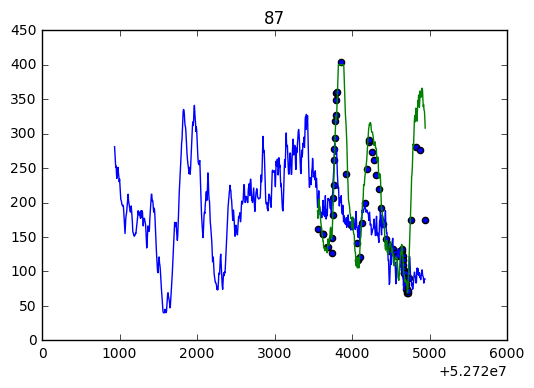

340
253


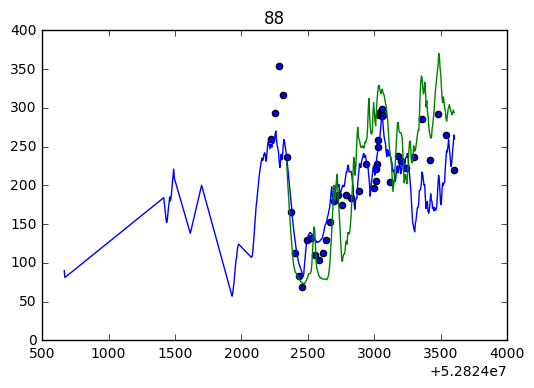

280
797


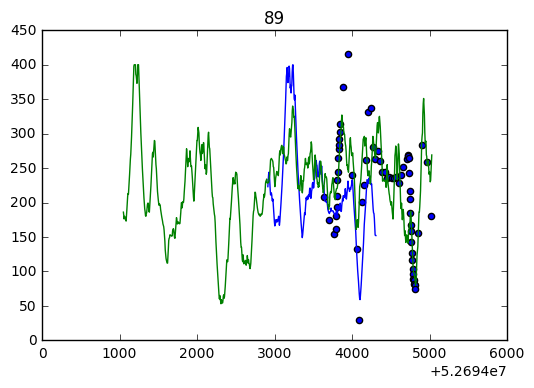

306
306


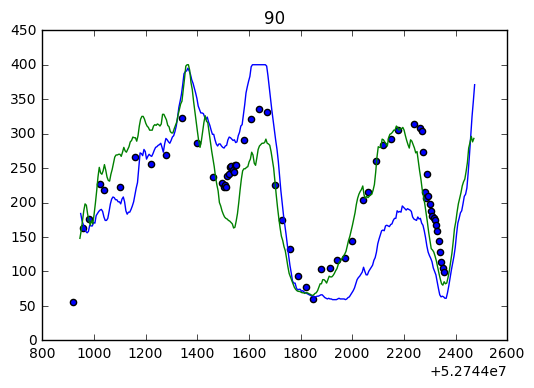

284
283


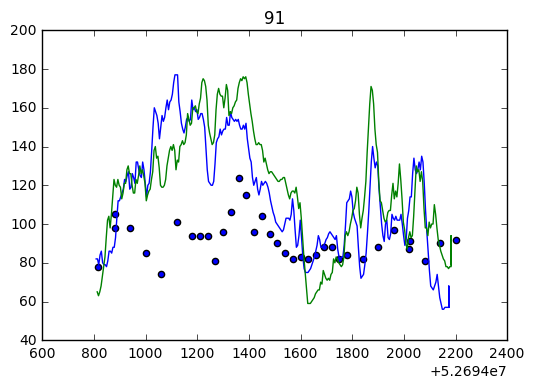

321
324


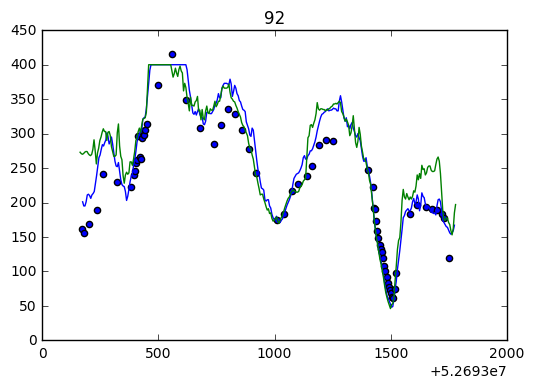

680
768


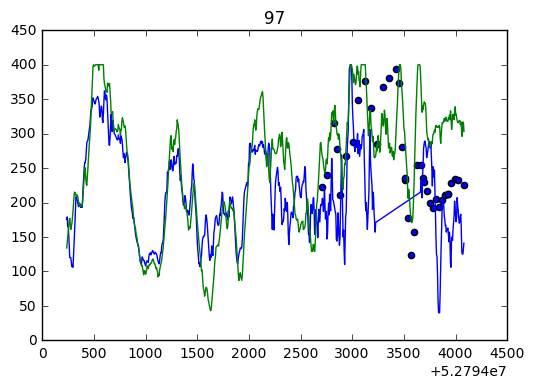

277
278


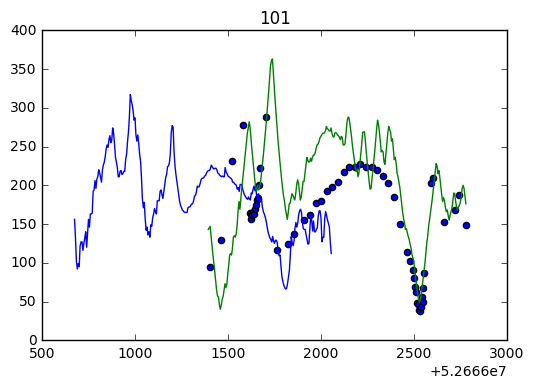

464
256


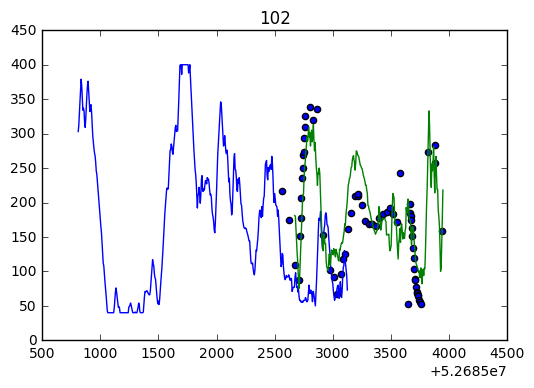

622
681


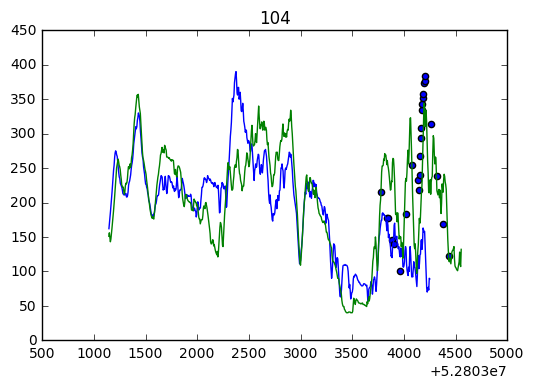

272
271


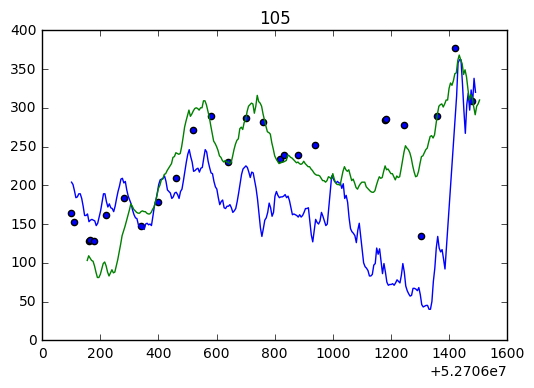

304
304


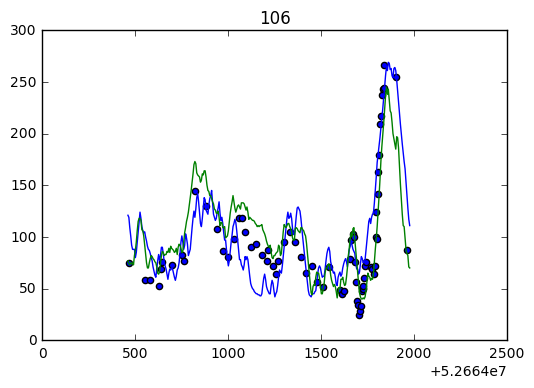

278
267


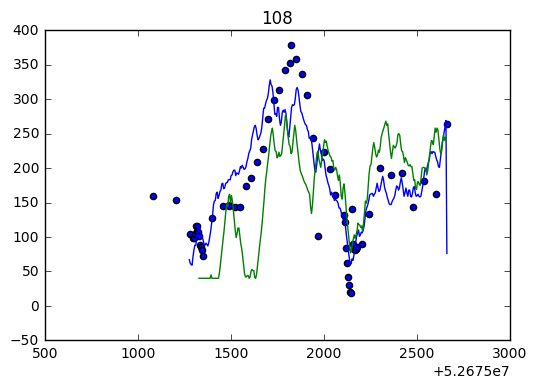

784
275


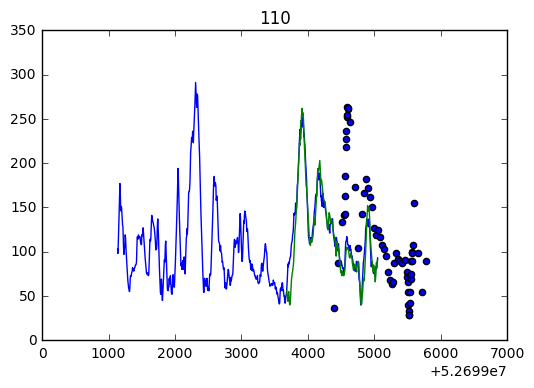

[ 60.  60.  30.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.  35.
  62.  58.  60.  30.  30.  30.  31.  29.  30.  30.  30.  30.  30.  30.  30.
  30.  30.  25.  15.  15.  35.  30.  30.  30.  47.  23.   5.   5.   5.   5.
   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.  25.  60.
  63.  57.]
252
279


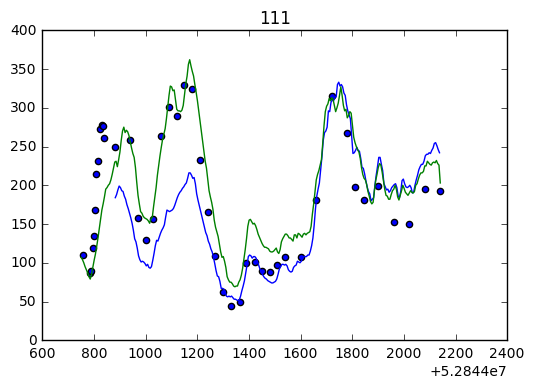

286
259


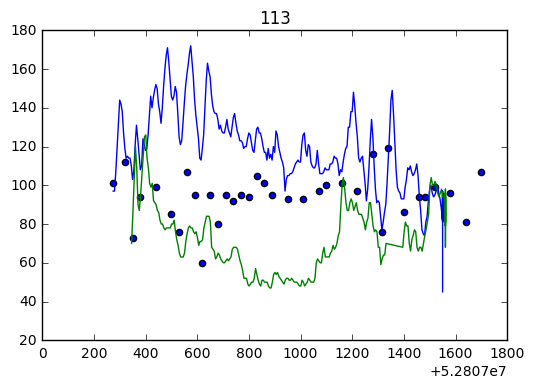

In [114]:
for key, value in pt_cgm.iteritems():
    if len(value) > 1 and key in bgm_data.keys():
        for data in value:
            plt.plot(data[:,0], data[:,1])
            print len(data)
            # blue, green, red
        plt.title(str(key))
        bgm = bgm_data[key]
        plt.scatter(bgm[:,0], bgm[:,1])
        plt.show()
        
        if key == 110:
            print np.diff(bgm[:,0])


In [108]:

# Save cgm patient data as pickle
with open('pt_true_bgm.p', 'r') as fp:
    bgm_data = pickle.load(fp)
print bgm_data.keys()

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113]
